# Reinforcement learning with Tensorflow

This code is supporting material for the book `Building Machine Learning Systems with Python` by [Willi Richert](https://www.linkedin.com/in/willirichert/), [Luis Pedro Coelho](https://www.linkedin.com/in/luispedrocoelho/) and [Matthieu Brucher](https://www.linkedin.com/in/matthieubrucher/) published by PACKT Publishing.

It is made available under the MIT License.

All code examples use Python in version...

In [1]:
import sys
sys.version

'3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) \n[GCC 7.2.0]'

## Utility functions

In [115]:
import os

CHART_DIR = "charts"
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)

def save_png(name):
    fn = 'B09124_13_%s.png'%name # please ignore, it just helps our publisher :-)
    plt.savefig(os.path.join(CHART_DIR, fn), bbox_inches="tight")

## Simple text games

In [2]:
import gym
import numpy as np

env = gym.make('FrozenLake-v0')

### Estimating the Q function the old fashion way

Let's make a table with some Q values for this environment

In [14]:
# Start with an empty table
Q = np.zeros((env.observation_space.n, env.action_space.n))
# Set learning hyperparameters
lr = .8
y = .95
num_episodes = 2000

# Let's run!
for i in range(num_episodes):
    # Reset environment and get first new observation (top left)
    s = env.reset()
    # Do 100 iterations to update the table
    for i in range(100):
        # Choose an action by picking the max of the table + additional random noise ponderated by the episode
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)//(i+1))
        # Get new state and reward from environment after chosen step 
        s1, r, d,_ = env.step(a)
        # Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        s = s1
        if d == True:
            break

In [15]:
print("Final Q-Table Values")
print(Q)

Final Q-Table Values
[[0.18118924 0.18976168 0.19044738 0.18260069]
 [0.03811294 0.19398589 0.18619181 0.18624451]
 [0.16266812 0.13309552 0.14401865 0.11183018]
 [0.02533285 0.12890984 0.02641699 0.15121063]
 [0.20015578 0.00201834 0.00902377 0.03619787]
 [0.         0.         0.         0.        ]
 [0.1294778  0.04845176 0.03590482 0.13001683]
 [0.         0.         0.         0.        ]
 [0.02543623 0.05444387 0.01170018 0.19347353]
 [0.06137181 0.43637431 0.00372395 0.00830249]
 [0.25205174 0.00709722 0.00908675 0.00296389]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.15032826 0.43034276 0.09982157]
 [0.         0.86241133 0.         0.        ]
 [0.         0.         0.         0.        ]]


### Test games with TF

In [16]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Let's create a new network.

In [92]:
y = 0.99
e = 0.1 # 1 in 10 samples, we chose a new action for the network
num_episodes = 2000
learning_rate = 0.1

In [111]:
tf.reset_default_graph()

# A simple one layer network
inputs = tf.placeholder(shape=[None, 16], dtype=tf.float32, name="input")
Qout = tf.layers.dense(
    inputs=inputs,
    units=4,
    use_bias=False,
    name="dense",
    kernel_initializer=tf.random_uniform_initializer(minval=0, maxval=.0125)
)
predict = tf.argmax(Qout, 1)

# Our optimizer will try to optimize 
nextQ = tf.placeholder(shape=[None, 4], dtype=tf.float32, name="target")
loss = tf.reduce_sum(tf.square(nextQ - Qout))

trainer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
updateModel = trainer.minimize(loss)

We can now train the network, and check that it will get more and more sucesses as the training progresses.

In [112]:
# To keep track of our games and our results
jList = []
rList = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(num_episodes):
        s = env.reset()
        rAll = 0
        
        for j in range(100):
            a, targetQ = sess.run([predict, Qout], feed_dict={inputs:np.identity(16)[s:s+1]})
            # We randomly choose a new state that we may have not encountered before
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()

            s1, r, d, _ = env.step(a[0])
            
            # Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout, feed_dict={inputs:np.identity(16)[s1:s1+1]})
            # Obtain maxQ' and set our target value for chosen action.
            targetQ[0, a[0]] = r + y*np.max(Q1)
            
            # Train our network using target and predicted Q values
            sess.run(updateModel, feed_dict={inputs:np.identity(16)[s:s+1], nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                # Reduce chance of random action as we train the model.
                e = 1 / ((i // 50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: %f%%" % (sum(rList) / num_episodes))

Percent of succesful episodes: 0.413000%


We now display the evolution of the reward with each episode

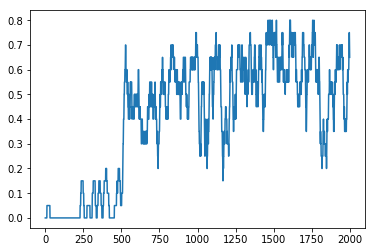

In [132]:
from scipy.signal import lfilter

plt.plot(lfilter(np.ones(20)/20, [1], rList))
save_png("reward")

We can also see that the survival increases, even if we take suoptimal paths:

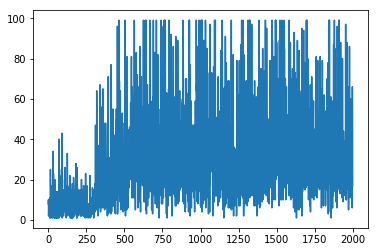

In [133]:
plt.plot(jList)
save_png("length")